# Number Plate Recognition using Azure Cognitive Services

In this example, I will utilise the custom vision service to detect number plate objects in the picture, then pass the number plate object to the text extraction service in Azure Cognitive Services. 

A custom vision mode was trained to detect number plates, and the prediciton API for the trained model was published to be used in this example. 

Your secrets.ini file should include the access key and url for the published customvision.ai prediction api and the Azure Cognitive Services instance. 

The format of the file is as follows: 
```
[custom_vision]
key = <your published prediction api key>
url = <URL for published custom vision prediction api, should end with /url>
imgurl = <URL for published custom vision predicition api, should end with /image>

[computer_vision]
key = <your computer vision api key>
url = https://australiaeast.api.cognitive.microsoft.com/ 
```

In [1]:
import configparser

config = configparser.ConfigParser()
config.read('secrets.ini')

# custom vision api
custom_vision_key = config['custom_vision']['key']
custom_vision_url = config['custom_vision']['url']
custom_vision_imgurl = config['custom_vision']['imgurl']

# computer vision text recognition api
subscription_key = config['computer_vision']['key']
endpoint = config['computer_vision']['url']
text_recognition_url = endpoint + "vision/v2.1/read/core/asyncBatchAnalyze"

In [2]:
import os
import sys
import requests
import time
import json
import base64
import numpy as np
import pandas as pd
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from io import BytesIO


In [3]:
custom_vision_headers = {'Content-Type': 'application/octet-stream', 'Prediction-Key': custom_vision_key}

# data = open('anpr_samples/hsv39.jpg', 'rb').read()
# data = open('anpr_samples/mcl650.jpg', 'rb').read()
data = open('anpr_samples/bike.jpg', 'rb').read()

# decode the image file as a cv2 image, useful for later to display results
img = cv2.imdecode(np.array(bytearray(data), dtype='uint8'), cv2.IMREAD_COLOR)

custom_vision_resp = requests.post(url=custom_vision_imgurl, data=data, headers=custom_vision_headers).json()

In [4]:
# inspect the top result, based on probability 

hit = pd.DataFrame(custom_vision_resp['predictions']).sort_values(by='probability',ascending=False).head(1).to_dict()
print(hit)

{'probability': {30: 0.926827848}, 'tagId': {30: '1752966c-d1e1-46f5-924b-505d90a16981'}, 'tagName': {30: 'plate'}, 'boundingBox': {30: {'left': 0.1388305, 'top': 0.486726224, 'width': 0.09517826, 'height': 0.079084456}}}


In [5]:
# extract the bounding box for the detected number plate 
boundingbox = list(hit['boundingBox'].values())[0]
l,t,w,h = (boundingbox['left'], boundingbox['top'], boundingbox['width'], boundingbox['height'])

In [6]:
print(l,t,w,h)
print('width, height')
print(img.shape[1],img.shape[0])
print([[l,t],[l+w,t],[l,t+h],[l+w,t+h]])
polylines1 = np.multiply([[l,t],[l+w,t],[l+w,t+h],[l,t+h]], [img.shape[1],img.shape[0]])
print(polylines1)

0.1388305 0.486726224 0.09517826 0.079084456
width, height
1244 700
[[0.1388305, 0.486726224], [0.23400875999999998, 0.486726224], [0.1388305, 0.56581068], [0.23400875999999998, 0.56581068]]
[[172.705142   340.7083568 ]
 [291.10689744 340.7083568 ]
 [291.10689744 396.067476  ]
 [172.705142   396.067476  ]]


In [7]:
# draw polylines based on bounding box results
# polylines = [[800,550],[920,550], [920,600], [800,600]]
img2 = cv2.polylines(img, np.int32([polylines1]), 1, (255,255,0), 4, lineType=cv2.LINE_AA )

In [8]:
# crop the image to the bounding box of the rego plate

crop_x = polylines1[:,0].astype('uint16')
crop_y = polylines1[:,1].astype('uint16')
img_crop = img2[np.min(crop_y):np.max(crop_y), np.min(crop_x):np.max(crop_x)]

print(np.min(crop_y),np.min(crop_x), np.max(crop_y),np.max(crop_x))
print(img2.shape)
print(img_crop.shape)


340 172 396 291
(700, 1244, 3)
(56, 119, 3)


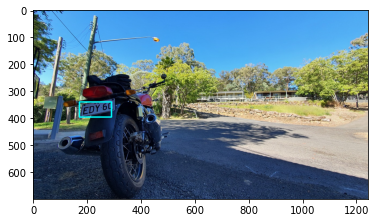

In [9]:
# display the detected rego plate region
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

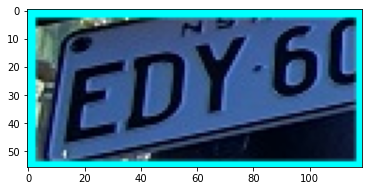

In [10]:
# display the cropped rego plate region

plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))


# Text recognition 

In this section, the cropped image for the detected rego plate is sent to the text extraction API. 

Extracting text requires two API calls: One call to submit the image for processing, the other to retrieve the text found in the image.


In [11]:
# convert the cv2 image to bytes array so we can send it over the wire to the API 
crop_bytes =bytes(cv2.imencode('.jpg', img_crop)[1])

In [12]:
# make a call to the text_recognition_url
response = requests.post(
    url=text_recognition_url, 
    data=crop_bytes, 
    headers={'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': 'application/octet-stream'})


In [13]:
# Holds the URI used to retrieve the recognized text.
response.raise_for_status()
operation_url = response.headers["Operation-Location"]

In [14]:
# The recognized text isn't immediately available, so poll to wait for completion.
analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers={'Ocp-Apim-Subscription-Key': subscription_key})
    analysis = response_final.json()
    print(analysis)
    time.sleep(1)
    if ("recognitionResults" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'Failed'):
        poll = False


{'status': 'Running'}
{'status': 'Succeeded', 'recognitionResults': [{'page': 1, 'clockwiseOrientation': 350.36, 'width': 119, 'height': 56, 'unit': 'pixel', 'lines': [{'boundingBox': [8, 17, 111, 0, 117, 30, 14, 48], 'text': 'EDY.60', 'words': [{'boundingBox': [12, 17, 111, 1, 114, 31, 16, 49], 'text': 'EDY.60', 'confidence': 'Low'}]}]}]}


In [15]:
for i,l in enumerate(analysis['recognitionResults'][0]['lines']): 
    print(i, ': text found: ', [w['text'] for w in l['words']])

0 : text found:  ['EDY.60']


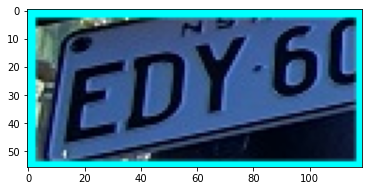

In [16]:
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
